# Eksploracja Danych - gladiatorzy

## Autorzy: Grzegorz Mazur, Marcin Ryt, Kamil Żebrok, Piotr Glajcar


Nasz dataset składa się z 29 kolumn:
- Imię i Nazwisko
- Wiek
- Rok urodzenia
- Region Pochodzenia
- Wzrost
- Waga
- Kategoria (styl walki, broń, etc.)
- Zwycięstwa
- Porażki
- Specjalne umiejętności
- Broń
- Majętność sponsora
- Jakość wyposażenia
- Przychylność widzów
- Historia urazów (czy gladiator miał dużo urazów czy mało)
- Mentalna wytrzymałość (umiejętność wytrzymania stresu i nacisku psychologicznego)
- Dieta
- Wiedza taktyczna
- Sieć lojalnych (sieć ludzi wspierających wojownika)
- Doświadczenie w walce
- Profil Psychologiczny
- Stan zdrowotny
- Osobista motywacja
- Zawód przed zostaniem gladiatorem
- Natężenie treningów
- Strategia walki
- Status Społeczny
- Techniki zyskania wsparcia publiczności
- Czy dany gladiator przeżył swoje walki



## Import bibliotek


In [ ]:
!pip install factor_analyzer
!pip install pyECLAT
!pip install pgmpy
!pip install prince
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import calculate_bartlett_sphericity,calculate_kmo
from factor_analyzer import FactorAnalyzer
from scipy.stats import bartlett
from prince import CA,MCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from pgmpy.models import BayesianModel
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator,MaximumLikelihoodEstimator,BayesianEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
from mlxtend.frequent_patterns import apriori,association_rules
from mlxtend.preprocessing import TransactionEncoder
from pyECLAT import ECLAT
import warnings
warnings.filterwarnings('ignore')

# api_token = {"username":"marc66","key":"8bfe874a9c2d4c4f0946a573d32c53c6"}
# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)
# import kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 295.6 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 29.0 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.0-py2.py3-none-any.whl size=42486 sha256=551ccf240bc8138196f03f2390d7b5de83eb8e10063668f289d78ce867919b78
  Stored in directory: /root/.cache/pip/wheels/74/a2/6c/26fb1addf1ce6c60a8cef8397f2999f0a1e6e2fcddc8abf33e
Successfully built factor_analyzer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 6.4 M

In [ ]:
#path_to_dataset = "sample_data/gladiator_data_small.csv"
path_to_dataset = "sample_data/gladiator_data.csv"
df = pd.read_csv(path_to_dataset, low_memory=False)
df_base=df
df=df.sample(n=1000).reset_index(drop=True)
print(df.head(10))

                  Name  Age  Birth Year    Origin  Height  Weight  \
0     Naevius Numicius   37          40  Germania     162      69   
1    Longinius Ninnius   22          52  Germania     159      58   
2     Afranius Caelius   23          30      Gaul     161      88   
3     Flavius Opellius   45          18      Gaul     155      92   
4     Munatius Fannius   28          33    Thrace     184      86   
5    Perperna Galerius   41           9      Gaul     163      81   
6     Naevius Nasidius   41          42      Rome     193      91   
7  Longinius Considius   35          46    Thrace     179      91   
8     Antonius Granius   44          40      Gaul     178      94   
9    Percennius Gnaeus   30          23      Gaul     169      87   

      Category  Wins  Losses Special Skills  ... Battle Experience  \
0    Retiarius     9       2         Novice  ...                11   
1   Provocator     6       0      Endurance  ...                 6   
2     Murmillo     7       3  

## Zamiana danych jakościowych na liczbowe (kody kategorii)

In [ ]:
#for column_name in df.columns[1:]:
#    if df[column_name].dtype in ['object', 'bool']:
#        df[column_name] = df[column_name].astype('category').cat.codes
#print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     1000 non-null   object 
 1   Age                      1000 non-null   int64  
 2   Birth Year               1000 non-null   int64  
 3   Origin                   1000 non-null   int8   
 4   Height                   1000 non-null   int64  
 5   Weight                   1000 non-null   int64  
 6   Category                 1000 non-null   int8   
 7   Wins                     1000 non-null   int64  
 8   Losses                   1000 non-null   int64  
 9   Special Skills           1000 non-null   int8   
 10  Weapon of Choice         1000 non-null   int8   
 11  Patron Wealth            1000 non-null   int8   
 12  Equipment Quality        1000 non-null   int8   
 13  Public Favor             1000 non-null   float64
 14  Injury History           

## Redukcja wymiarów

Redukcję wymiarów przeprowadzimy na kolumnach z wartościami zmiennoprzecinkowymi.

In [ ]:
df_dim_red = df.select_dtypes(include=["float64","int64"]).reset_index(drop=True)
print(df_dim_red[1:])
print(df_dim_red[1:].info())

     Age  Birth Year  Height  Weight  Wins  Losses  Public Favor  \
1     22          52     159      58     6       0      0.595270   
2     23          30     161      88     7       3      0.571669   
3     45          18     155      92    17       5      1.055426   
4     28          33     184      86     5       2      0.527590   
5     41           9     163      81     8       2      0.637564   
..   ...         ...     ...     ...   ...     ...           ...   
995   24          50     182      44     5       2      0.563544   
996   32          31     172      69     7       2      0.618678   
997   37          39     161     102     7       0      0.804137   
998   38          23     175      87     7       0      0.606922   
999   24          57     179     107     5       1      0.535309   

     Mental Resilience  Battle Experience  SurvivedAge  
1            10.616452                  6            2  
2             9.056493                 10            2  
3           

### PCA
Jest to technika redukcji wymiarowości, która może być użyteczna na dużych datasetach z wieloma parametrami, takimi jak ten. Wprowadzając pewne zmienne "sztuczne" (nieobserwowalne) będące pewnymi kombinacjami liniowymi naszych parametrów wejściowych można zachować istotne informacje, używając mniejszej liczby zmiennych, co może znaczaco poprawić wydajność.

Uzupełnienie brakujących danych wartościami średnimi i standaryzacja

In [ ]:
names_column = df['Name'].reset_index(drop=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_dim_red), columns=df_dim_red.columns)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

Wykres Łokcia w celu wyboru odpowiedniej ilości komponentów

[0, 0.3838344075735188, 0.5074477754488605, 0.6209111135360972, 0.721456345368918, 0.816956391156891, 0.9034463641864219, 0.958002284049678, 0.9905327403017553, 1.0]


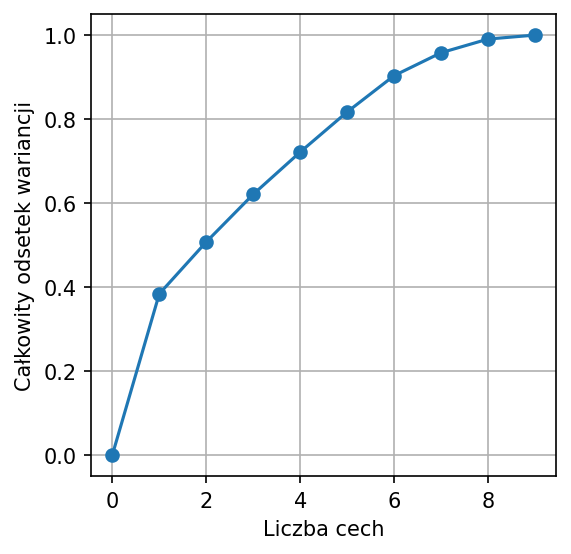

In [ ]:
component_number=np.arange(len(df_imputed.columns))
total_variance_ratios = []
for n in component_number:
    pca = PCA(n_components=n)
    pca.fit_transform(X_scaled)
    total_variance_ratios += [sum(pca.explained_variance_ratio_)]
plt.figure(figsize=(4,4), dpi=150)
plt.grid()
plt.plot(component_number, total_variance_ratios,marker='o')
plt.xlabel("Liczba cech")
plt.ylabel("Całkowity odsetek wariancji")
print(total_variance_ratios)

Wybraliśmy 5-6 składników ze względu na kryterium Cattellego (łokieć) i procentowe (prawie 90% łącznej wyjaśnionej wariancji).

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Name'] = names_column
print(df_pca.head(3))
print(df_pca.shape)

        PC1       PC2       PC3       PC4       PC5               Name
0  0.474471  0.115282  0.647124 -0.327142 -1.273896   Naevius Numicius
1 -2.470197 -1.498042  1.734618 -1.627253 -1.374742  Longinius Ninnius
2 -0.838471 -0.702178  1.894582  0.016996 -0.794485   Afranius Caelius
(1000, 6)


###  FA - Analiza Czynnikowa

Tutaj, podobnie jak w PCA, celem jest zastąpienie oryginalnych zmiennych mniejszą liczbą nowych zmiennych (czynników), które dodatkowo, o ile to możliwe, wyjaśniają zależności pomiędzy nimi.

Sprawdzenie zasadniczości i adekwatności zastosowania analizy czynnikowej - test sferyczności Bartletta i test Kaisera-Maiera-Olkina

In [ ]:
chi_sqaure_value,p_value=calculate_bartlett_sphericity(df_dim_red) #<- bez pierwszego rekordu działa
print(chi_sqaure_value,p_value)

37413.89329896372 0.0


p-value wyszło równe 0 -> macierz korelacji nie jest jednostkowa, co oznacza, że występują znaczne korelacje między zmiennymi.

In [ ]:
kmo_all, kmo_model=calculate_kmo(df_dim_red[1:])
print(kmo_model)

0.5980656766421427


KMO wyszło około 0.6 - możemy to zaakceptować i uznać analizę za adekwatną

In [ ]:
fa=FactorAnalyzer(n_factors=len(df_dim_red.columns[1:]),rotation=None)
fa.fit(df_dim_red)
ev,v=fa.get_eigenvalues()
print(ev)

[3.74180846e+00 1.13917950e+00 1.03277223e+00 9.69355089e-01
 8.60748693e-01 8.27918664e-01 3.25148298e-01 1.03069064e-01
 4.99600357e-16]


Na bazie kryterium Kaisera, należy wybrać 3 składniki.

### CA

Correspondence Analysis to kolejna technika redukcji wymiarów, podobna do PCA i FA, jednak dotyczy wyłącznie cech jakościowych. Jej celem jest przekształcenie tabeli kontyngencji zawierającej częstości występowania kombinacji kategorii w przestrzeń o niższej wymiarowości. Dzięki temu można wizualizować wzorce korelacji między zmiennymi kategorialnymi.

Analizę korespondencji przeprowadzamy na 2 cechach, więc wybraliśmy `Origin` i `Social Standing` oraz `Origin` i `Weapon of Choice`.

In [ ]:
df_CA=pd.crosstab(df['Origin'],df['Social Standing'])
print(df_CA)

Social Standing  High  Low  Medium
Origin                            
Gaul               37   34      93
Germania           43   36      91
Greece             55   29      93
Numidia            36   33      91
Rome               45   25      98
Thrace             37   33      91


In [ ]:
ca=CA(n_components=2)
ca=ca.fit(df_CA)
ca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.006,80.21%,80.21%
1,0.002,19.79%,100.00%


Tutaj widzimy że możemy pozostać przy 1 komponencie (dużo wyjaśnionej wariancji).


In [ ]:
df_CA=pd.crosstab(df['Origin'],df['Weapon of Choice'])
print(df_CA)
ca=CA(n_components=5)
ca=ca.fit(df_CA)
ca.eigenvalues_summary

Weapon of Choice  Dagger  Gladius (Sword)  Net  Sica (Curved Sword)  Spear  \
Origin                                                                       
Gaul                  76               44    7                   13     12   
Germania              72               41   12                   16     11   
Greece                78               42    7                   10     17   
Numidia               66               36   12                   16     15   
Rome                  71               47   11                   18     10   
Thrace                75               38   15                   14     12   

Weapon of Choice  Trident  
Origin                     
Gaul                   12  
Germania               18  
Greece                 23  
Numidia                15  
Rome                   11  
Thrace                  7  


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.014,63.25%,63.25%
1,0.004,19.24%,82.49%
2,0.003,13.54%,96.03%
3,0.001,3.61%,99.64%
4,0.000,0.36%,100.00%


Bierzemy 3 komponenty (ponad 90% wyjaśnionej wariancji)

### MCA

Wielowymiarowa Analiza Korespondencji jest rozwinięciem klasycznego CA, przeprowadzana jest w
sytuacji, w której obiekty są opisane za pomocą więcej niż dwóch zmiennych o charakterze jakościowym.

In [ ]:
df_MCA=df.select_dtypes(include=["object","bool"])
print(df_MCA)

                 Name    Origin     Category Special Skills  \
0       Mucius Hirrus   Numidia  Hoplomachus         Novice   
1    Decimus Afranius    Greece       Thraex         Novice   
2     Laberius Modius  Germania     Murmillo         Novice   
3      Ninnius Pedius   Numidia       Thraex        Tactics   
4    Opellius Fidenas    Greece  Hoplomachus         Novice   
..                ...       ...          ...            ...   
995    Catius Atilius    Greece     Murmillo          Speed   
996   Iulius Galerius      Gaul   Provocator         Novice   
997     Iunius Balbus    Greece      Secutor         Novice   
998  Iunius Lucretius      Rome  Hoplomachus         Novice   
999  Paconius Sextius      Rome     Murmillo         Novice   

        Weapon of Choice Patron Wealth Equipment Quality Injury History  \
0                 Dagger           Low             Basic            Low   
1                 Dagger          High          Superior            Low   
2        Gladius (

Wrzucając cały dataset, otrzymalibyśmy ponad 100 componentów, więc analizę zastosujemy 20 pierwszych wierszach.

In [ ]:
mca = MCA(
    n_components=20,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_MCA.head(20))
print(mca.eigenvalues_summary)


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.372        10.77%                     10.77%
1              0.342         9.92%                     20.69%
2              0.293         8.49%                     29.18%
3              0.259         7.52%                     36.70%
4              0.246         7.13%                     43.83%
5              0.219         6.35%                     50.18%
6              0.209         6.05%                     56.23%
7              0.192         5.55%                     61.78%
8              0.169         4.89%                     66.67%
9              0.163         4.72%                     71.40%
10             0.147         4.26%                     75.66%
11             0.138         3.99%                     79.65%
12             0.129         3.73%                     83.38%
13             0.113         3.26%                     86.64%
14      

Wg kryterium procentowego, możemy wziąć 15 komponentów.

## Klasteryzacja/grupowanie

Są to techniki stosowane do podziału zbioru danych na grupy, zwane klastrami, w taki sposób, że obiekty wewnątrz jednej grupy są podobne do siebie, a jednocześnie różnią się od obiektów w innych grupach. Obiekty podlegające temu procesowi mogą być opisane zmiennymi różnych typów.

### KMeans


Metoda ta początkowo dzieli zbiór danych na k klastrów i wybierane są ich centroidy. Następnie obiekty są przypisywane do klastrów na podstawie odległości od centroidów, a te są aktualizowane jako średnie wartości cech obiektów w klastrze. Proces jest powtarzany, aż przypisanie obiektów do klastrów ustabilizuje się.

Żeby określić optymalną liczbę klastrów, możemy zastosować metrykę WCSS (Within Cluster Sum of Squares). Im mniejsze jest WCSS, tym bardziej oddalone są klastry względem siebie. Za duża ilość klastrów może przeciwdziałać temu i wprowadzić większy chaos, więc musimy wybrać optymalną wartość. (Zbyt mała liczba klastrów źle by pokazywała pozycje klastrów)

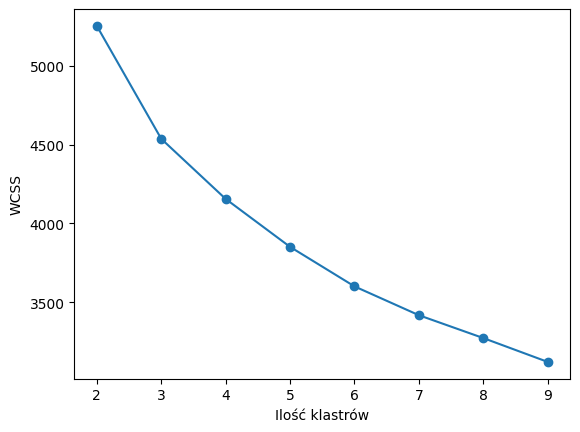

In [ ]:
wcss = []
for i in range(2,10):
  kmeans = KMeans(n_clusters=i, random_state=3)
  kmeans.fit(X_pca)
  wcss += [kmeans.inertia_]
x = np.arange(2,10)
plt.plot(x,wcss,marker="o")
plt.xlabel("Ilość klastrów")
plt.ylabel("WCSS")
plt.show()

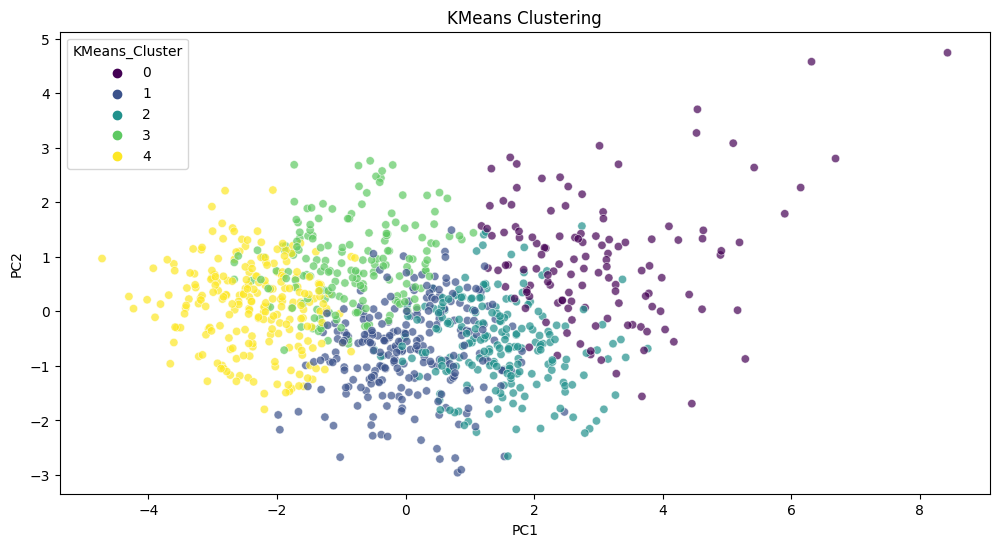

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=3)
df_pca['KMeans_Cluster'] = kmeans.fit_predict(X_pca)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=df_pca, palette='viridis', alpha=0.7)
plt.title('KMeans Clustering')
plt.show()

### Metoda Warda

Ta technika minimalizuje wariancję wewnątrz klastrów podczas łączenia ich w trakcie procesu aglomeracji. Algorytm wybiera pary klastrów, które po połączeniu prowadzą do minimalnego wzrostu wariancji. Kryterium Warda jest systematycznie aktualizowane, a proces trwa, aż cały zbiór danych zostanie połączony w jeden klaster.

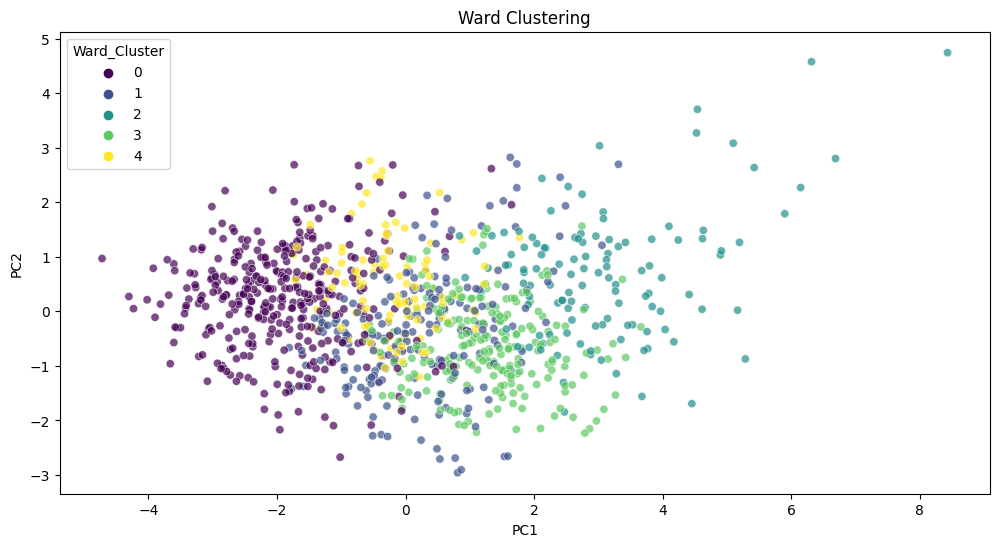

In [ ]:
ward_cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
df_pca['Ward_Cluster'] = ward_cluster.fit_predict(X_pca)


plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Ward_Cluster', data=df_pca, palette='viridis', alpha=0.7)
plt.title('Ward Clustering')
plt.show()


### Dendrogram

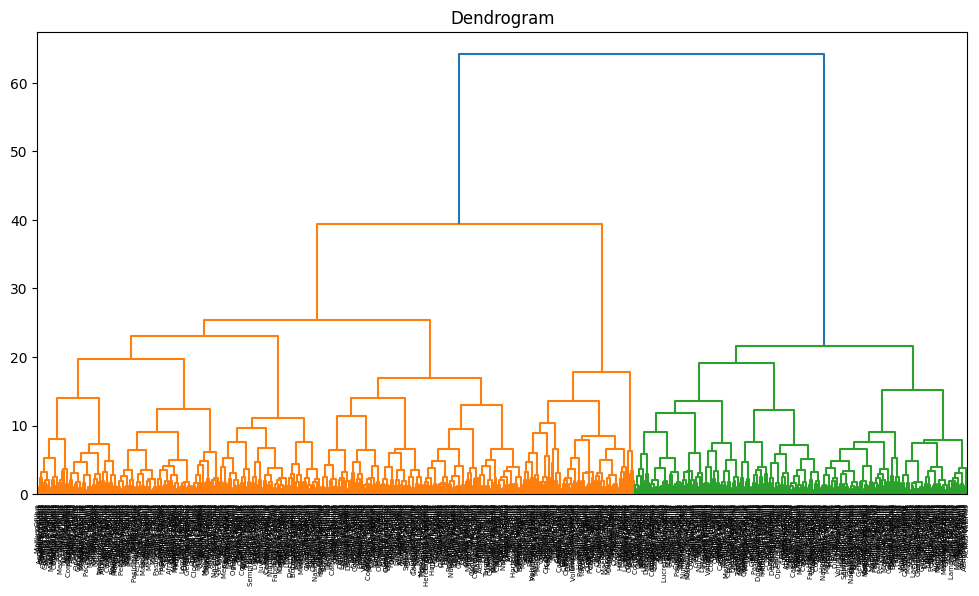

In [ ]:
linkage_matrix = linkage(X_pca, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, orientation='top', labels=df_pca['Name'].tolist(), distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()


## Klasyfikacja

 Celem klasyfikacji jest stworzenie modelu, który może nauczyć się wzorców i zależności na danych treningowych, umożliwiając późniejsze przewidywanie klasy nowych obiektów.

W celu wykonanania lepszej klasyfikacji, sprawdziliśmy korelacje między cechami kategorycznymi (jakościowymi).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     1000 non-null   object 
 1   Age                      1000 non-null   float64
 2   Birth Year               1000 non-null   float64
 3   Origin                   1000 non-null   int8   
 4   Height                   1000 non-null   float64
 5   Weight                   1000 non-null   float64
 6   Category                 1000 non-null   int8   
 7   Wins                     1000 non-null   float64
 8   Losses                   1000 non-null   float64
 9   Special Skills           1000 non-null   int8   
 10  Weapon of Choice         1000 non-null   int8   
 11  Patron Wealth            1000 non-null   int8   
 12  Equipment Quality        1000 non-null   int8   
 13  Public Favor             1000 non-null   float64
 14  Injury History           

<Axes: >

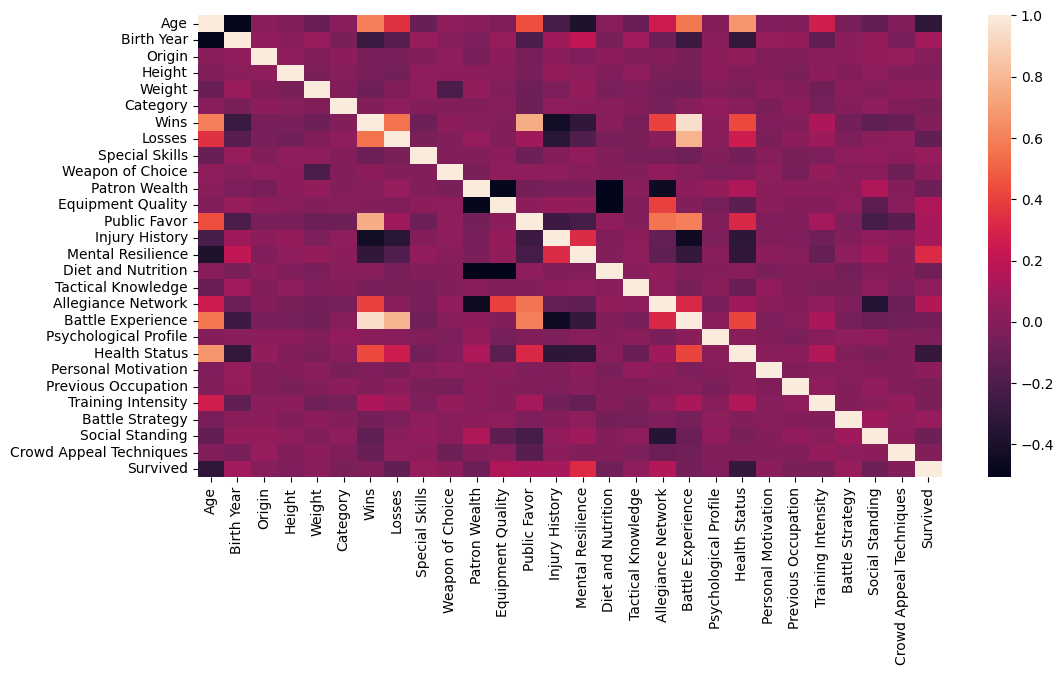

In [ ]:
df_numbered=df.copy()
for column_name in df_numbered.columns[1:]:
    if df_numbered[column_name].dtype in ['object', 'bool']:
        df_numbered[column_name] = df_numbered[column_name].astype('category').cat.codes
print(df_numbered.info())
print(df_numbered.head(5))
corr=df_numbered.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr)

Z wykresu można zauważyć że mocno skorelowane są kategorie `Age` z `Wins`, `Battle Experience`, `Health Status` i `Public Favor`.

Zatem, o te kolumny oprzemy klasyfikację.

### KNN - K Nearest Neighbours

Metoda polega na klasyfikacji obiektów w zbiorze testowym za pomocą określenia która klasa występuje w k najbliższych obiektach ze zbioru treningowego. Kluczowe w optymalnym zastosowaniu klasyfikacji jest dobranie 'k', żeby klasyfikacja była jak najbardziej trafna (za duże k może spowodować przeuczenie, za małe może nie wskazywać)

In [ ]:
df_pca["SurvivedAge"]=df["Survived"].astype(int)*2+(df["Age"]>=35)
print(df_pca)

          PC1       PC2       PC3       PC4       PC5                 Name  \
0    0.474471  0.115282  0.647124 -0.327142 -1.273896     Naevius Numicius   
1   -2.470197 -1.498042  1.734618 -1.627253 -1.374742    Longinius Ninnius   
2   -0.838471 -0.702178  1.894582  0.016996 -0.794485     Afranius Caelius   
3    5.286311  0.607086  1.289027  1.292881 -1.181843     Flavius Opellius   
4   -1.093872  0.142807 -0.754070 -0.018668  0.525989     Munatius Fannius   
..        ...       ...       ...       ...       ...                  ...   
995 -1.614779  0.189307 -0.143244 -2.717084 -0.086789  Antonius Pasidienus   
996 -0.180905  1.884703 -1.142332  0.009315 -1.097443        Aulus Caelius   
997  0.078649 -1.900454  0.184024  1.608725 -0.765294  Longinius Novellius   
998 -0.638462 -2.552870 -0.210374  0.121601 -0.210728    Vibius Hordeonius   
999 -1.999948  0.134624  0.345689  1.080959  1.145115    Ofilius Iuventius   

     SurvivedAge  
0              1  
1              2  
2     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


X = df_pca.drop(axis=1,columns=["Name"])
y = df_pca["SurvivedAge"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k_value = 5

knn_model = KNeighborsClassifier(n_neighbors=k_value)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 98.00%


### Naiwny Klasyfikator Bayesa

Algorytm zakłada niezależność między cechami, co pomaga w prostym modelowaniu. Proces klasyfikacji polega na obliczeniu prawdopodobieństwa przynależności do każdej klasy dla danego obiektu, uwzględniając występowanie poszczególnych cech. Następnie, obiekt jest przypisywany do klasy o najwyższym prawdopodobieństwie.

In [ ]:
features = ['Wins', 'Public Favor', 'Injury History', 'Battle Experience']

df['Age35'] = (df['Age'] > 35).astype(int)
target = ['Age35']

X = df[features]
y = df[target]
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Dokładność klasyfikacji dla (wiek <= 35 i > 35): {accuracy}')

Dokładność klasyfikacji dla (wiek <= 35 i > 35): 0.685


Z ciekawości sprawdźmy czy wszystkie kategoryczne kolumny pomagają określić przetrwanie gladiatora.

In [ ]:
#wybrac sobie część z tych dla zwiększenia accuracy
features = ['Origin', 'Height', 'Weight', 'Category', 'Wins', 'Losses',
 'Special Skills', 'Weapon of Choice', 'Patron Wealth', 'Equipment Quality',
 'Public Favor', 'Injury History', 'Mental Resilience', 'Diet and Nutrition',
 'Tactical Knowledge', 'Allegiance Network', 'Battle Experience',
 'Psychological Profile', 'Health Status', 'Personal Motivation',
 'Previous Occupation', 'Training Intensity', 'Battle Strategy',
 'Social Standing', 'Crowd Appeal Techniques']

target = "Survived"

X = df[features]
y = df[target].astype(int)
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Dokładność klasyfikacji dla Survived: {accuracy}')

Dokładność klasyfikacji dla Survived: 0.66


### Sieć Bayesa

Jest to bardziej rozbudowana koncepcja niż naiwny klasyfikator Bayesa. W sieci Bayesa wykorzystuje się strukturę grafu, która reprezentuje zależności między różnymi zmiennymi, a w kontekście klasyfikacji, między cechami a klasą.







In [ ]:
# https://pgmpy.org/models/bayesiannetwork.html
df_selected = df[['Age35', 'Survived', 'Injury History']]
train_data = df_selected[:800]
predict_data = df_selected[800:]

#tabela CPT (Conditional Probability Table) dla zmiennych
cpt_age35 = model.get_cpds('Age35')
cpt_survived = model.get_cpds('Survived')
cpt_injury_history = model.get_cpds('Injury History')

print("CPD dla Age35:")
print(cpt_age35)
print("\nCPD dla Survived:")
print(cpt_survived)
print("\nCPD dla Injury History:")
print(cpt_injury_history)

model = BayesianNetwork([('Age35', 'Survived'), ('Age35', 'Injury History'), ('Survived', 'Injury History')])
model.fit(train_data)
predict_data = predict_data.copy()
predict_data.drop('Survived', axis=1, inplace=True)
y_pred = model.predict(predict_data)
print(y_pred)

CPD dla Age35:
+----------+---------+
| Age35(0) | 0.64625 |
+----------+---------+
| Age35(1) | 0.35375 |
+----------+---------+

CPD dla Survived:
+-----------------+--------------------+---------------------+
| Age35           | Age35(0)           | Age35(1)            |
+-----------------+--------------------+---------------------+
| Survived(False) | 0.2901353965183752 | 0.6643109540636042  |
+-----------------+--------------------+---------------------+
| Survived(True)  | 0.7098646034816247 | 0.33568904593639576 |
+-----------------+--------------------+---------------------+

CPD dla Injury History:
+----------------------+---------------------+-----+--------------------+----------------+
| Age35                | Age35(0)            | ... | Age35(1)           | Age35(1)       |
+----------------------+---------------------+-----+--------------------+----------------+
| Survived             | Survived(False)     | ... | Survived(False)    | Survived(True) |
+--------------------

  0%|          | 0/4 [00:00<?, ?it/s]

     Survived
0        True
1       False
2       False
3        True
4        True
..        ...
195      True
196     False
197      True
198      True
199      True

[200 rows x 1 columns]


### Drzewa decyzyjne

Drzewo jest grafem bez cykli i jego tworzenie rozpoczynamy od korzenia, z którego wychodzą krawędzie
reprezentujące wartości cech. W trakcie trenowania modelu, drzewo jest budowane poprzez podział zbioru danych na podgrupy, tak aby maksymalizować jednolitość wewnątrz klastrów i zminimalizować różnice między nimi.

Dokładność modelu: 0.74


[Text(0.3379092261904762, 0.9666666666666667, 'Wins <= 4.5\ngini = 0.363\nsamples = 800\nvalue = [191, 609]'),
 Text(0.09642857142857143, 0.9, 'Public Favor <= 115.5\ngini = 0.468\nsamples = 139\nvalue = [87, 52]'),
 Text(0.06190476190476191, 0.8333333333333334, 'Age <= 11.0\ngini = 0.252\nsamples = 61\nvalue = [52, 9]'),
 Text(0.0380952380952381, 0.7666666666666667, 'Category <= 3.5\ngini = 0.168\nsamples = 54\nvalue = [49, 5]'),
 Text(0.01904761904761905, 0.7, 'Battle Experience <= 5.5\ngini = 0.051\nsamples = 38\nvalue = [37, 1]'),
 Text(0.009523809523809525, 0.6333333333333333, 'gini = 0.0\nsamples = 34\nvalue = [34, 0]'),
 Text(0.02857142857142857, 0.6333333333333333, 'Previous Occupation <= 3.0\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.01904761904761905, 0.5666666666666667, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.0380952380952381, 0.5666666666666667, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.05714285714285714, 0.7, 'Weight <= 27.5\ngini = 0.375\n

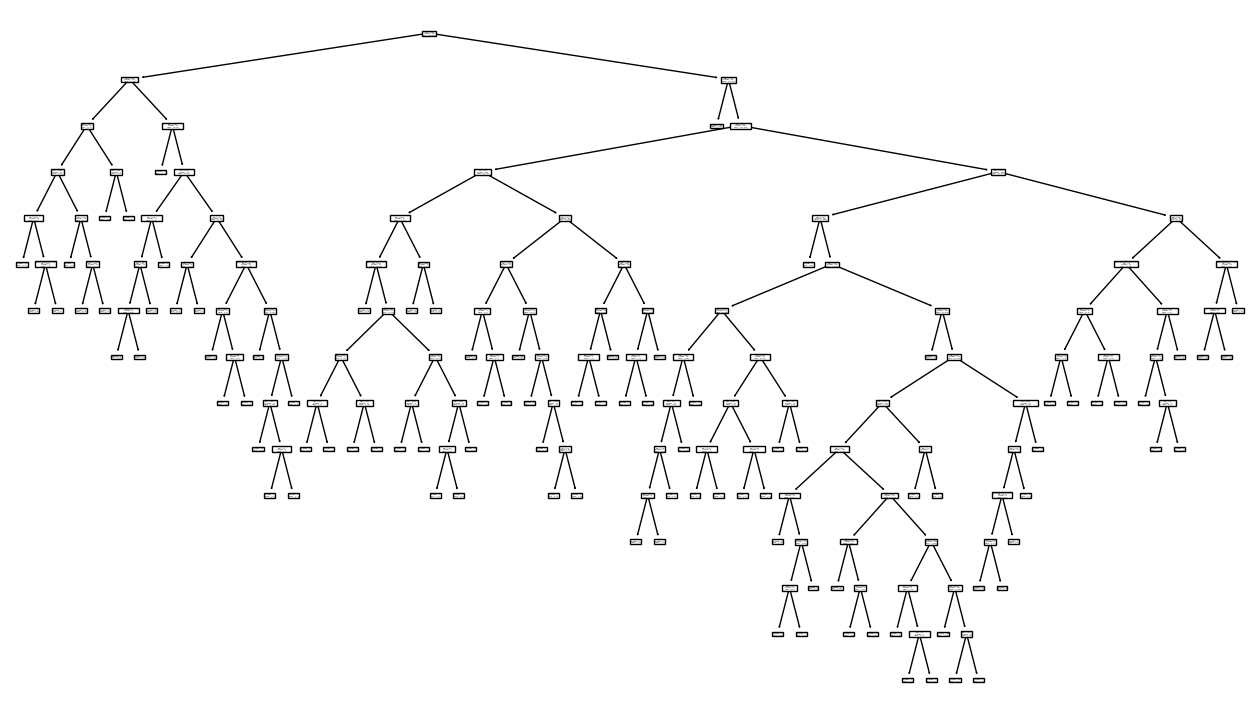

In [ ]:
X = df.drop('Survived', axis=1)
y = df['Survived']

#konwersja kategorialnych tekstowych na liczby (Label Encoding)
label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Dokładność modelu: {accuracy:.2f}')
plt.figure(figsize=(16,9))
plot_tree(clf,feature_names=X.columns.values)

### Bonus: SVC na bazie klasteryzacji

Tutaj w ramach bonusa zastosowaliśmy klasyfikator z użyciem maszyn wektorów wspierających (SVM), przewidujący do którego klastra dany rekord należy. Bazujemy na kolumnach liczbowych, na których zastosowano PCA.

In [ ]:
target_column = 'Ward_Cluster'

X = df_pca.drop(['Name', target_column], axis=1)
y = df_pca[target_column]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

svc_model = SVC(kernel='linear', C=1.0)#C to współczynnik regularyzacji
svc_model.fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
#pokazać y_pred i y_test jednocześnie żeby zobaczyć fizycznie jak mu szło
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        78
           1       0.76      0.83      0.79        35
           2       0.86      0.71      0.78        35
           3       0.77      0.80      0.78        25
           4       0.71      0.74      0.73        27

    accuracy                           0.85       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.85      0.85      0.85       200



## Reguły asocjacyjne i wzorce sekwencji


Zanim zaczniemy wykrywanie zbiorów częstych, musimy zmienić formę danych na tranzakcje.

In [ ]:
#Get elements into Transaction form
transaction_form=[]
object_columns=df.drop(axis=1,columns=["Name","Survived"]).select_dtypes(include=["object"]).columns.values
print(object_columns)
for i in range(len(df)):
  transaction=df.loc[i][object_columns].values.tolist()
  for i,column_name in enumerate(object_columns):
    transaction[i]=column_name+"_"+transaction[i]
  transaction_form+=[transaction]
print(transaction_form)

['Origin' 'Category' 'Special Skills' 'Weapon of Choice' 'Patron Wealth'
 'Equipment Quality' 'Injury History' 'Diet and Nutrition'
 'Tactical Knowledge' 'Allegiance Network' 'Psychological Profile'
 'Health Status' 'Personal Motivation' 'Previous Occupation'
 'Training Intensity' 'Battle Strategy' 'Social Standing'
 'Crowd Appeal Techniques']
[['Origin_Germania', 'Category_Retiarius', 'Special Skills_Novice', 'Weapon of Choice_Trident', 'Patron Wealth_High', 'Equipment Quality_Superior', 'Injury History_Low', 'Diet and Nutrition_Excellent', 'Tactical Knowledge_Basic', 'Allegiance Network_Strong', 'Psychological Profile_Fearful', 'Health Status_Excellent', 'Personal Motivation_Vengeance', 'Previous Occupation_Criminal', 'Training Intensity_Medium', 'Battle Strategy_Aggressive', 'Social Standing_High', 'Crowd Appeal Techniques_Humble'], ['Origin_Germania', 'Category_Provocator', 'Special Skills_Endurance', 'Weapon of Choice_Gladius (Sword)', 'Patron Wealth_Low', 'Equipment Quality_Basic

## Apriori

Algorytm Apriori pozwala w prosty sposób wykryć zbiory częste, które są podstawą do wykrycia reguł asocjacyjnych. Polega on na sprawdzaniu coraz to większych zbiorów, składających się z elementów będących częścią zbiorów częstych (opracowanych w poprzednim kroku).


In [ ]:
te=TransactionEncoder()
transactions=te.fit(transaction_form).transform(transaction_form)
df_transactions=pd.DataFrame(transactions,columns=te.columns_)
print(df_transactions)
items_total = df_transactions.astype(int).sum(axis=0).sort_values()
print(items_total)
# Find frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(df_transactions, min_support=0.2, use_colnames=True)

# Display the frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Generate association rules
association_rules_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display the association rules
print("\nAssociation Rules:")
print(association_rules_df)

     Allegiance Network_Moderate  Allegiance Network_Strong  \
0                          False                       True   
1                          False                       True   
2                          False                       True   
3                          False                       True   
4                          False                       True   
..                           ...                        ...   
995                        False                       True   
996                        False                       True   
997                         True                      False   
998                        False                       True   
999                        False                       True   

     Allegiance Network_Weak  Battle Strategy_Aggressive  \
0                      False                        True   
1                      False                       False   
2                      False                       False   
3  

## ECLAT

Algorytm ECLAT bazuje na pojęciu zbioru domkniętego, czyli takiego którego żaden nadzbiór nie ma równego wsparcia co ten zbiór, i zbioru maksymalnego, czyli takiego którego żaden nadzbiór nie jest zbiorem częstym. W skrócie, szuka się wszystkich maksymalnych, domkniętych zbiorów częstych i wybiera się te podzbiory które są zbiorami częstymi.

In [ ]:
df_transactions=pd.DataFrame(transaction_form,columns=np.arange(len(transaction_form[0])))
print(df_transactions)
eclat=ECLAT(data=df_transactions)
print(eclat.df_bin)
total_per_variants = eclat.df_bin.astype(int).sum(axis=0)
#wszystkie tranzakcje mają tyle samo elementów

                  0                    1                         2   \
0    Origin_Germania   Category_Retiarius     Special Skills_Novice   
1    Origin_Germania  Category_Provocator  Special Skills_Endurance   
2        Origin_Gaul    Category_Murmillo    Special Skills_Agility   
3        Origin_Gaul      Category_Thraex     Special Skills_Novice   
4      Origin_Thrace      Category_Thraex    Special Skills_Agility   
..               ...                  ...                       ...   
995      Origin_Gaul   Category_Retiarius    Special Skills_Tactics   
996      Origin_Gaul      Category_Thraex     Special Skills_Novice   
997      Origin_Gaul    Category_Murmillo     Special Skills_Novice   
998   Origin_Numidia     Category_Secutor     Special Skills_Novice   
999   Origin_Numidia     Category_Secutor  Special Skills_Endurance   

                                   3                     4   \
0            Weapon of Choice_Trident    Patron Wealth_High   
1    Weapon of Choice

In [ ]:
min_support = 0.05
min_combination = 2
max_combination = 4 #żeby się liczyło w ludzkim czasie
rule_indices, rule_supports = eclat.fit(min_support=min_support, min_combination=min_combination,max_combination=max_combination,separator=' & ',verbose=True)

Combination 2 by 2


2485it [00:24, 101.29it/s]


Combination 3 by 3


57155it [08:22, 113.83it/s]


Combination 4 by 4


971635it [2:18:06, 117.26it/s]


In [ ]:
result = pd.DataFrame(rule_supports.items(),columns=['Variant', 'Support'])
result.sort_values(by=['Support'], ascending=False)

,Variant,Support
208,Health Status_Excellent & Injury History_Low,0.578
384,Injury History_Low & Training Intensity_Medium,0.535
382,Injury History_Low & Allegiance Network_Strong,0.486
407,Injury History_Low & Special Skills_Novice,0.463
521,Allegiance Network_Strong & Training Intensity...,0.443
...,...,...
4254,Patron Wealth_Medium & Social Standing_Medium ...,0.050
8103,Allegiance Network_Strong & Training Intensity...,0.050
4274,Patron Wealth_Medium & Personal Motivation_Glo...,0.050
4275,Patron Wealth_Medium & Weapon of Choice_Gladiu...,0.050


### CLOSET+

CLOSET+ jako algorytm stosuje łączenie obiektów, czyli w sytuacji, gdy we wszystkich tranzakcjach, gdzie występuje zbiór częsty X, występuje zbiór Y i nie występuje nadzbiór zbioru Y, to łączymy X i Y w jeden domknięty zbiór częsty i pomijamy elementy poprzednio zbioru X w analizie elementów. Jeśli natomiast zbiór X jest nadzbiorem Y (zbioru częstego) i $supp(X)=supp(Y)$, to oznacza że elementy w zbiorze X niebędące częścią zbioru Y należy wyrzucić ze zbioru, czego dokonuje się tzw. przycinaniem zbiorów.

Posiadamy kod do tego algorytmu, jednak, jakoże został napisany w Pythonie, jest długi, bardzo wolny i liczy się godzinami, dlatego postanowiliśmy o nim wspomnieć lecz nie zastosować go w tym projekcie.